In [1]:
import numpy as np
import pandas as pd
from sklearn import tree, ensemble
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.inspection import permutation_importance

# Tree Ensembles 

## Assignment overview 

In this assignment you will build two types of tree ensemble models: Random Forest and Boosted. You will then investigate two methods for feature selection. 

###### Outline:


- [Part 1](#part1)- Importing the data set and formatting it 
- [Part 2](#part2)- Fitting a single decision tree
- [Part 3](#part3)- Using a Random Forest Classifier
- [Part 4](#part4)- Using the AdaBoost Classifier
- [Part 5](#part5)- Choosing the best classifier and retraining using all the samples, testing on the test set
- [Part 6](#part6)- Feature selection


[Back to top](#Index:) 

<a id='part1'></a>

### Part 1 - Importing the data set

For this excercise we will be using a data set from the University of Medicine and Pharmacy of Craiova, Romania to predict the hospitalisation period of patients after colon cancer operations based on socio-economic variables and clinical information. You can read more about the data and it's origins [here](https://figshare.com/articles/dataset/LOS_Colon_Cancer_621_cases/4747246/1). 

The data is stored in xlsx format again in the `colon_data.xlsx` file. Use the `read_excel()` function to load it.

In [2]:
df = pd.read_excel("data\colon_data.xlsx")
len(df)

298

Use the `.head()` function to visulise the data.

In [3]:
df.head()

,AGE,SEX,TOPOGRAPHY,STAGE,T,N,M,SURGERY,CLASS
0,64,M,rect,three,T4,Nx,Mx,ten,medium
1,70,M,rect,three,T4,Nx,Mx,ten,medium
2,76,F,cec,three,T3,Nx,Mx,three,medium
3,62,M,cec,three,T2,Nx,Mx,three,short
4,62,M,cec,two,T2,Nx,Mx,three,short


First we want to replace the categorical values of the output (the `CLASS` variable) with numerical values. Fill in the gaps below to use the `.replace()` function to do this.

In [4]:
df.CLASS.unique() 

array(['medium', 'short', 'long'], dtype=object)

In [5]:
df['CLASS'].replace(to_replace=['short','medium','long'] , value=[0,1,2] , inplace=True) 

In [6]:
df.head()

,AGE,SEX,TOPOGRAPHY,STAGE,T,N,M,SURGERY,CLASS
0,64,M,rect,three,T4,Nx,Mx,ten,1
1,70,M,rect,three,T4,Nx,Mx,ten,1
2,76,F,cec,three,T3,Nx,Mx,three,1
3,62,M,cec,three,T2,Nx,Mx,three,0
4,62,M,cec,two,T2,Nx,Mx,three,0


Now use the `get_dummies()` function to transform the other categorical variables to numerical ones. 

In [7]:
df = pd.get_dummies(df)

In [8]:
df.head()

,AGE,CLASS,SEX_F,SEX_M,TOPOGRAPHY_cec,TOPOGRAPHY_colon_asc,TOPOGRAPHY_colon_desc,TOPOGRAPHY_colon_sigm,TOPOGRAPHY_colon_trans,TOPOGRAPHY_jonc_rect_sigm,...,N_N1,N_N2,N_Nx,M_M0,M_M1,M_M1_hep,M_Mx,SURGERY_ten,SURGERY_three,SURGERY_two
0,64,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1,70,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
2,76,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
3,62,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,62,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0


The following cell is just to ensure the 'CLASS' variable is the last column.

In [9]:
columns = df.columns.to_list()
columns.remove('CLASS')
df = df[columns + ['CLASS']]

In [10]:
df.head()

,AGE,SEX_F,SEX_M,TOPOGRAPHY_cec,TOPOGRAPHY_colon_asc,TOPOGRAPHY_colon_desc,TOPOGRAPHY_colon_sigm,TOPOGRAPHY_colon_trans,TOPOGRAPHY_jonc_rect_sigm,TOPOGRAPHY_rect,...,N_N2,N_Nx,M_M0,M_M1,M_M1_hep,M_Mx,SURGERY_ten,SURGERY_three,SURGERY_two,CLASS
0,64,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,1
1,70,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,1
2,76,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
3,62,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4,62,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


We will now process the data similar to how we did for the loan data set activity.

Run the cell below to convert the `df` into a `NumPy` array

In [11]:
Xy=np.array(df)

For reproducibility, set the random seed = 1. You can do this by using the `NumPy` function `random.seed()`. Assign your seed to the variable `seed`. Next, complete the code cell below by using the function `random.shuffle()` on `Xy`.

In [12]:
seed = np.random.seed(1)


Before splitting the data into a training set, a test set, and a validation set, we need to divide `Xy` into two arrays: the first one, `X`, a 2D array containing all the predictors and the second, `y`, a 1D array with the response. 

Run the code cell below to generate `X`. Complete the remaining code to define `y`.

In [13]:
X=Xy[:,:-1]
y=Xy[:,-1]

In [14]:
#define y
y=Xy[:,-1]

Next, we need to split the messages into into 50% training data, 25% validation data, and 25% test data.

Run the code below to split `X` and `y` into training, validation and test sets.

In [15]:
trainsize = int(len(df)/2)
trainplusvalsize = int(len(df)/4)
X_train=X[:trainsize]
X_val=X[trainsize:trainsize + trainplusvalsize]
X_test=X[trainsize + trainplusvalsize:]

y_train=y[:trainsize]
y_val=y[trainsize:trainsize + trainplusvalsize]
y_test=y[trainsize + trainplusvalsize:]

[Back to top](#Index:) 

<a id='part2'></a>

### Part 2: Fit a Single Decision Tree 

Use the same code as you used for the loan dataset notebook to fit decision trees with different depths up to `max_depth = 15`. Select the best depth - you will compare this to your tree ensemble methods later. 

In [16]:
from sklearn.tree import DecisionTreeClassifier

max_depth = 15
bestdepth=-1
bestscore = 0

for i in range(15):
    clf = DecisionTreeClassifier()
    #fit the training sets
    clf.fit(X_train,y_train )
    #update trainscore
    trainscore= clf.score(X_train,y_train)
    #update valscore
    valscore= clf.score(X_val,y_val)
    print( 'Depth:', i+1, 'Train Score:', trainscore, 'Validation Score:', valscore)
    if  valscore > bestscore  :
        #update bestscore
        bestscore= valscore
        
        #update depth
        bestdepth= i+1
        

Depth: 1 Train Score: 0.9932885906040269 Validation Score: 0.7027027027027027
Depth: 2 Train Score: 0.9932885906040269 Validation Score: 0.7027027027027027
Depth: 3 Train Score: 0.9932885906040269 Validation Score: 0.6891891891891891
Depth: 4 Train Score: 0.9932885906040269 Validation Score: 0.6891891891891891
Depth: 5 Train Score: 0.9932885906040269 Validation Score: 0.7162162162162162
Depth: 6 Train Score: 0.9932885906040269 Validation Score: 0.7162162162162162
Depth: 7 Train Score: 0.9932885906040269 Validation Score: 0.6756756756756757
Depth: 8 Train Score: 0.9932885906040269 Validation Score: 0.7027027027027027
Depth: 9 Train Score: 0.9932885906040269 Validation Score: 0.7027027027027027
Depth: 10 Train Score: 0.9932885906040269 Validation Score: 0.7027027027027027
Depth: 11 Train Score: 0.9932885906040269 Validation Score: 0.7027027027027027
Depth: 12 Train Score: 0.9932885906040269 Validation Score: 0.6891891891891891
Depth: 13 Train Score: 0.9932885906040269 Validation Score: 0

***Question***

What is the best maximum depth? 
[Jing's answer]: Both depths 5 and 6 has the same highest validation score, 0.7162. However, we might favor simpler models when performance is similar. Therefore, I choose depth 5 as the best maximum depth. 

***Double click on this cell to enter your answer***


[Back to top](#Index:) 

<a id='part3'></a>

## Part 3: Random Forest

In this section you will learn how to build a random forest model in sklearn and explore the effect of the `max_features` hyperparameter. 

Use the `ensemble.RandomForestClassifier()` function to build a random forest model with the default parameters. Use the `.fit()` function to train it, the same as you did for the decision tree. 

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=1)

# Fit the classifier to the training data
rf_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=1)

In [27]:
print ( 'Full tree guess train/validation ',rf_clf.score(X_train, y_train),rf_clf.score(X_val, y_val))

Full tree guess train/validation  0.9932885906040269 0.7162162162162162


In random forest classifiers, the algorithm only considers a subset of the features at each split. This is controlled using the `max_features` argument. Normally this subset size is set to the square root of the total number of features, but here we will look at both setting it to the square root `"sqrt"` (this is the default in sklearn) and to `None`. when `max_features = None` the algorithm is using all the features at every split. 


In [25]:
# for loop looking at RF with different max_features 

np.random.seed(1)
# Iterates over two settings for max_features: "sqrt" (which is the default in sklearn and represents the square root of the number of features) and None (which means all features are considered at every split)
for max_features in ["sqrt",  None]:
    # build the rf classifier wwith different arguments for max_features
    #fit to the training data
    rf_clf = RandomForestClassifier(max_features=max_features,random_state=1)
    
    # Fit to the training data
    rf_clf.fit(X_train, y_train)

    print ( f'Full tree guess train/validation {max_features}',rf_clf.score(X_train, y_train),rf_clf.score(X_val, y_val))


Full tree guess train/validation sqrt 0.9932885906040269 0.7162162162162162
Full tree guess train/validation None 0.9932885906040269 0.7432432432432432


***Question***

Which method performs best? Why might this be?
[Jing's answer]: 
`random_seed=1`:
Full tree guess train/validation sqrt 0.9932885906040269 0.7162162162162162
Full tree guess train/validation None 0.9932885906040269 0.7432432432432432

With max_features=None, the training score is again 0.9933, but the validation score is higher at 0.7432. The method with max_features=None (using all features at every split) performs better in terms of validation score. 

This allows the model to consider all features at each split and provides a more comprehensive set of options for finding the best splits, potentially capturing more complex patterns in the data. This can be particularly beneficial if there are important interactions between features that are only captured when all features are considered together.

Rerun the cell above with different random seeds (but remember to set it back to `random_seed=1`). What happens? Why is this?
[Jing's answer]: 
`random_seed=10`:
Full tree guess train/validation sqrt 0.9932885906040269 0.7027027027027027
Full tree guess train/validation None 0.9932885906040269 0.7297297297297297
These scores are slightly lower compared to the scores obtained with random_seed=1. This variation in performance illustrates the impact of randomness in the random forest algorithm. It can lead to variations in model performance with different seeds.

***Double click on this cell to enter your answer***



[Back to top](#Index:) 

<a id='part4'></a>

## Part 4: Boosting

For our boosting algorithm we will use scikit learn's AdaBoost. This boosting algorithm works by building an ensemble of weak classifiers (in our case decision trees) by sequentially weighting the incorrectly classified instances. 



Use the .AdaBoostClassifier() to build a boosting model and fit it to the training data.

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ab_clf = AdaBoostClassifier(random_state=1)
ab_clf.fit(X_train,y_train)


AdaBoostClassifier(random_state=1)

In [24]:
print ( 'Full tree guess train/validation ',ab_clf.score(X_train, y_train),ab_clf.score(X_val, y_val))

Full tree guess train/validation  0.6308724832214765 0.581081081081081


[Back to top](#Index:) 

<a id='part5'></a>

## Part 5: Model Selection

***Question***

Which model would you use for this dataset? Decision tree, Random Forest or Boosting? Why? 
[Jing's answer]:
Decision Tree:
Train Score: ~0.9933
Best Validation Score: ~0.7162 (at depth 5 or 6)

Random Forest (with random_seed=1):
Train Score: 0.9933
Best Validation Score: 0.7432 (with max_features=None)

AdaBoost:
Train Score: 0.6309
Validation Score: 0.5811

Given these results, the Random Forest model appears to be the best choice based on the following reasons:
Higher Validation Accuracy: The Random Forest model with max_features=None has the highest validation score among the three models.
Balance Between Bias and Variance: While the decision tree model also shows high training accuracy, its validation performance is slightly lower than the Random Forest. This could indicate overfitting in the case of the decision tree, which random forests can mitigate through ensemble learning.

***Double click on this cell to enter your answer***



Retrain the best model with both the training and validation data and test it on the test data.

In [28]:
X_trainval = X[:trainsize + trainplusvalsize, :]
y_trainval = y[:trainsize + trainplusvalsize]

best_clf = RandomForestClassifier(max_features=None,random_state=1)
best_clf.fit(X_trainval,y_trainval)

print ( 'Full tree guess train/validation ',best_clf.score(X_trainval, y_trainval),best_clf.score(X_test, y_test))

Full tree guess train/validation  0.9865470852017937 0.8133333333333334


[Back to top](#Index:) 

<a id='part6'></a>

# Part 6: Feature Selection

Feature selection can help us understand our model and the outputs it gives us, as well as remove any irrelevant predictors. In this section we will be looking at how to identify the most important features in a decision tree using two different methods:
- Impurity metric approaches
- Permutation Importances 

We will be looking at feature selection for your best model (`best_clf`)

Use the `.feature_importances_` function to get the inbuilt impurity metric measure. Then use the `.argsort()` 
function to sort the resulting feature importances. 



In [30]:
feature_importances = best_clf.feature_importances_
sorted_idx = feature_importances.argsort()

Get the feature names from the dataframe columns `.columns`. Remember to remove the last column from the list as this is the output column.

In [31]:
feature_names = df.columns[:-1]

Use the function below to plot the importances.

In [32]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances")
    fig.tight_layout()
    plt.show()



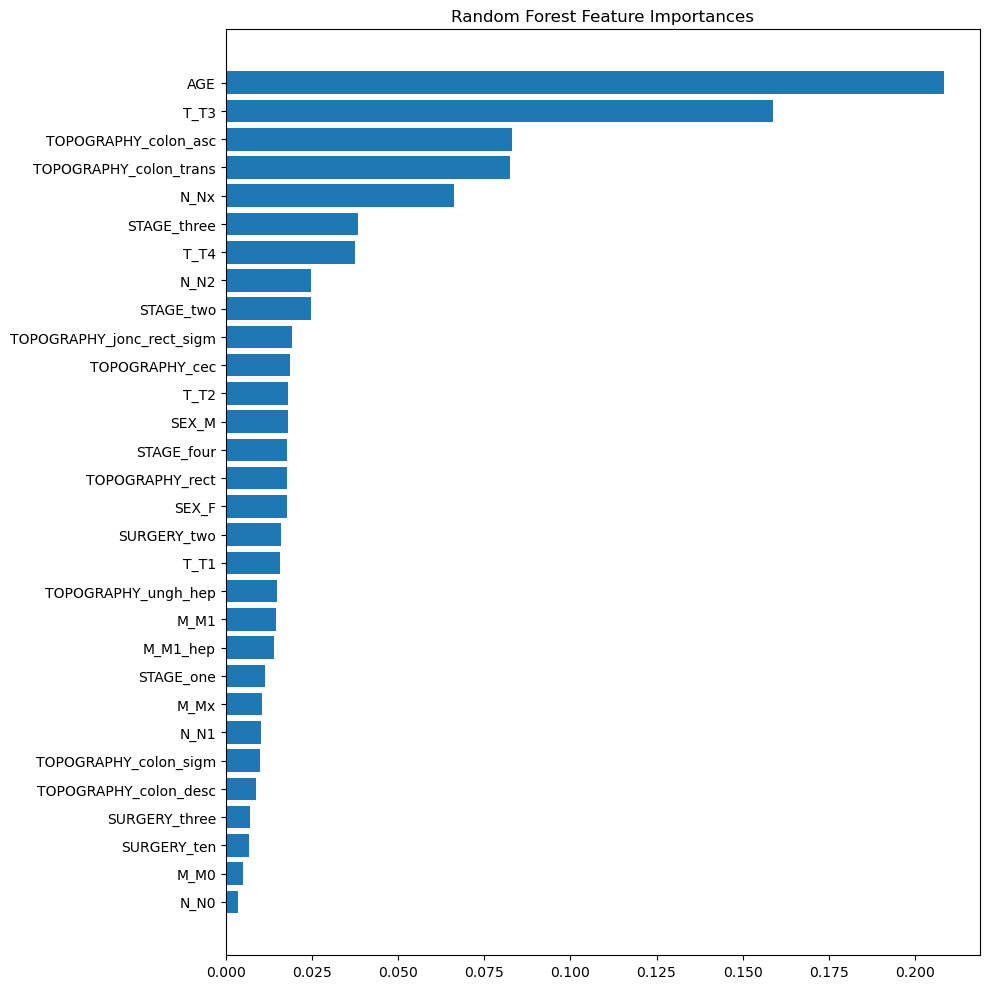

In [33]:
# plot the impurity metric feature importances 
plot_impurity_metric_features(feature_importances,sorted_idx,feature_names)


***Question***

What are the 3 most important features? 
[Jing's answer]: The most important features are AGE, T_T3 and TOPOGRAPHY_colon_asc.

***Double click on this cell to enter your answer***


One of the downsides of the inbuilt impurity metric is that it can only be applied to training data. This doesn't give us any indication of which features will be the most important on unseen data. 

Instead, we can use the permutation importance to measure the feature importances on both the training and validation sets. 

Complete the `permutation_importance` function to calculate the importance of the diffierent features in the training dataset. Then use the `argsort()` to sort the features in order of importance again.

In [34]:
from sklearn.inspection import permutation_importance

# permutation method on both training and test

result = permutation_importance(estimator=best_clf , X=X_train , y=y_train , n_repeats=10, random_state=1, n_jobs=2)

sorted_idx = result.importances_mean.argsort()



Use the function below to plot the permutation importances.

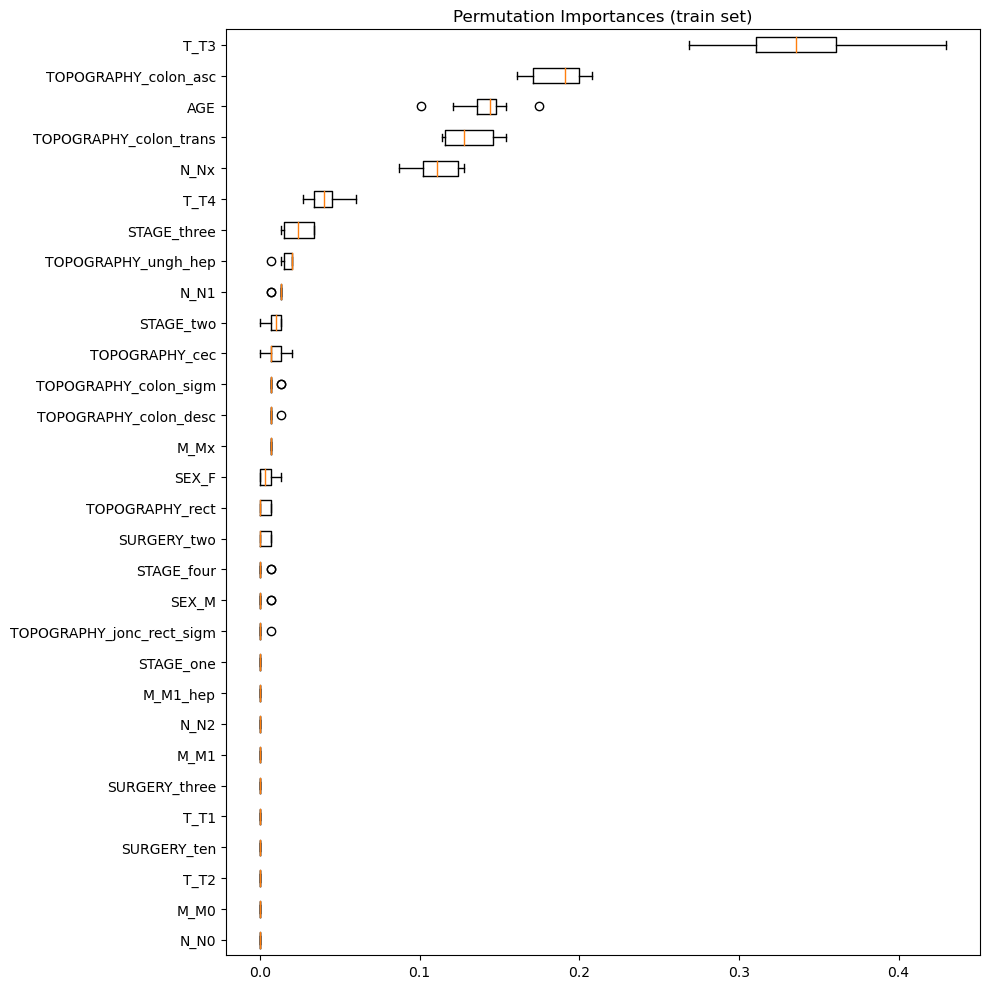

In [35]:

def plot_perm_importance(result, sorted_idx, feature_names):

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
    )
    ax.set_title("Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()
    
plot_perm_importance(result, sorted_idx, feature_names)


What do you notice about the difference between the two methods of doing feature selection? Why do you think this is?
[Jing's answer]: The most important features are AT_T3, TOPOGRAPHY_colon_asc and TOPOGRAPHY_colon_trans. 

Impurity-based methods measure importance based on how much a feature decreases the impurity within the trees, which is a more theoretical measure. Permutation importance measures the decrease in model performance when the feature's information is removed, which is a practical measure of dependency.

***Double click on this cell to enter your answer***



Now calculate the permutation importance on the test set. 

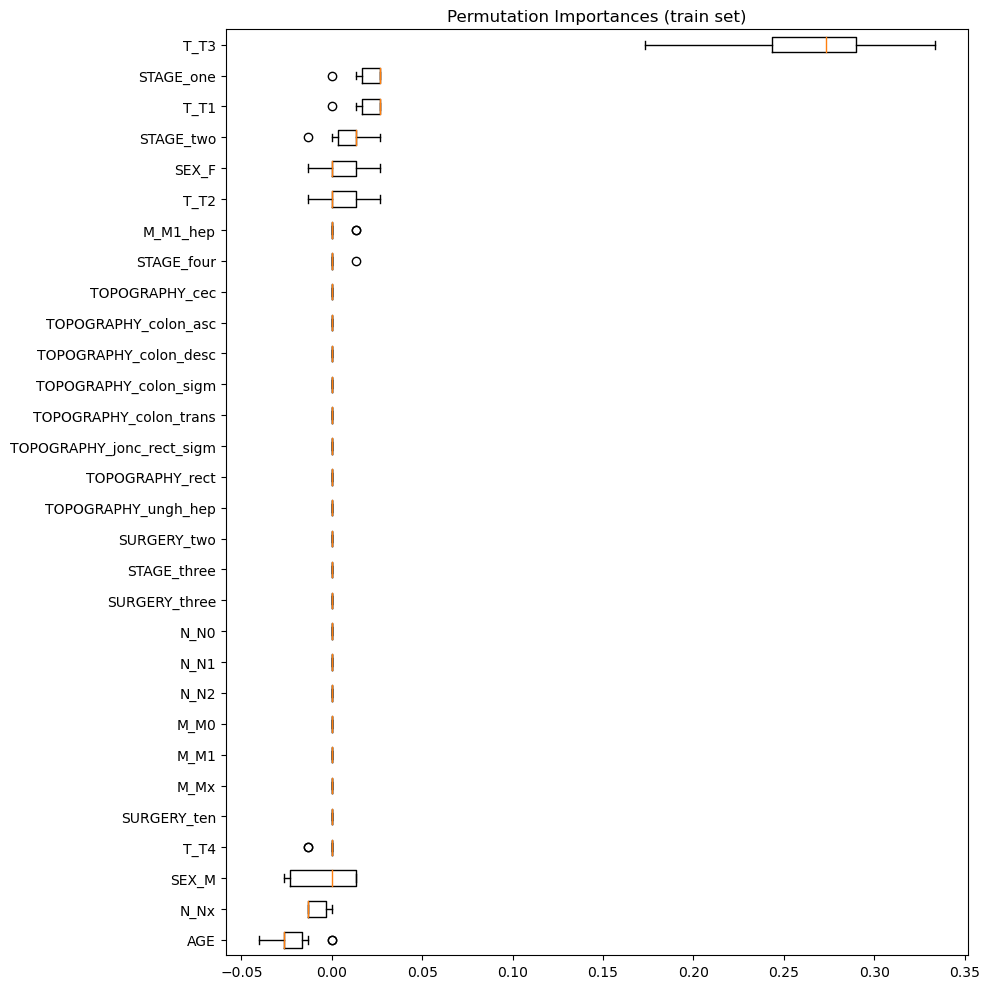

In [36]:
result = permutation_importance(estimator=best_clf , X=X_test , y=y_test , n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

plot_perm_importance(result, sorted_idx, feature_names)

What do you see in the test data?
[Jing's answer]: Some features have negative importance scores.

Why do some of the importances go negative?
[Jing's answer]: This could mean that the predictions on the test data happened to be more accurate than the training data.

***Double click on this cell to enter your answer***


(3 marks)